In [1]:
from google.colab import files
files.upload()

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d kiranmahesh/nslkdd

  0% 0.00/2.56M [00:00<?, ?B/s]
100% 2.56M/2.56M [00:00<00:00, 79.2MB/s]


In [3]:
from zipfile import ZipFile
file_name='/content/nslkdd.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [4]:
from __future__ import print_function
from imblearn.over_sampling import ADASYN
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.utils import np_utils
import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter




In [5]:
traindata = pd.read_csv('/content/kdd_train.csv')
testdata = pd.read_csv('/content/kdd_test.csv')

In [6]:
data = pd.concat([traindata,testdata])
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [7]:
categ = ['protocol_type','service','flag','labels']
# Encode Categorical Columns
le = LabelEncoder()
data[categ] = data[categ].apply(le.fit_transform)

In [10]:
indexNames = data[ data['labels'] == 35 ].index
# Delete these row indexes from dataFrame
data.drop(indexNames , inplace=True)

In [11]:
X= data.iloc[:,1:42]
Y=data['labels']

In [12]:
scaler = Normalizer().fit(X)
X= scaler.transform(X)

In [15]:
sm = SMOTE(random_state=42,k_neighbors=1)
X_res, y_res = sm.fit_resample(X, Y)

In [16]:
X_train , X_test , Y_train , Y_test = train_test_split(X,Y, test_size=0.2)

In [17]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))


In [22]:
model = Sequential()
model.add(GRU(128,input_shape=(41, 1)))  # try using a GRU instead, for fun
model.add(Dropout(0.1))
model.add(Dense(41))
model.add(Activation('softmax'))




In [23]:
# try using different optimizers and different optimizer configs
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
checkpointer = callbacks.ModelCheckpoint(filepath="kddresults/lstm1layer/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')

In [25]:
history=model.fit(X_train, Y_train, epochs=70,verbose=1,batch_size=500,validation_data=(X_test, Y_test),callbacks=[checkpointer])

Epoch 1/70
238/238 [==============================] - 7s 20ms/step - loss: 1.5131 - accuracy: 0.5202 - val_loss: 1.3183 - val_accuracy: 0.5334
Epoch 2/70
238/238 [==============================] - 5s 19ms/step - loss: 1.3321 - accuracy: 0.5274 - val_loss: 1.3024 - val_accuracy: 0.5334
Epoch 3/70
238/238 [==============================] - 4s 18ms/step - loss: 1.1318 - accuracy: 0.6541 - val_loss: 0.8878 - val_accuracy: 0.7495
Epoch 4/70
238/238 [==============================] - 5s 19ms/step - loss: 0.6685 - accuracy: 0.8264 - val_loss: 0.5731 - val_accuracy: 0.8611
Epoch 5/70
238/238 [==============================] - 4s 18ms/step - loss: 0.5494 - accuracy: 0.8543 - val_loss: 0.5151 - val_accuracy: 0.8684
Epoch 6/70
238/238 [==============================] - 4s 18ms/step - loss: 0.5117 - accuracy: 0.8600 - val_loss: 0.5005 - val_accuracy: 0.8656
Epoch 7/70
238/238 [==============================] - 4s 18ms/step - loss: 0.4798 - accuracy: 0.8649 - val_loss: 0.4533 - val_accuracy: 0.8752

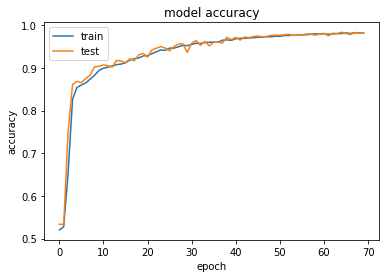

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

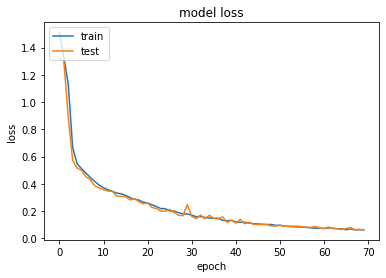

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()